In [25]:
# imports
import os 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, recall_score,
f1_score, confusion_matrix, roc_curve, precision_recall_curve)

import xgboost as xgb

In [26]:
# loading the data
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [29]:
print("Loaded Dataset's Shape : ",df.shape)

Loaded Dataset's Shape :  (299, 13)


In [30]:
df.columns.tolist()

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time',
 'DEATH_EVENT']

#### EDA

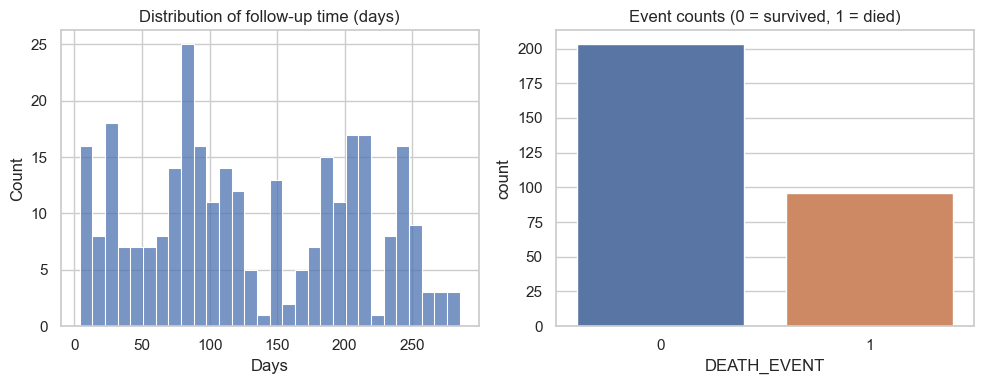

In [31]:
# basic EDA
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['time'], bins=30)
plt.title('Distribution of follow-up time (days)')
plt.xlabel('Days')


plt.subplot(1,2,2)
sns.countplot(x='DEATH_EVENT', data=df)
plt.title('Event counts (0 = survived, 1 = died)')
plt.xlabel('DEATH_EVENT')
plt.tight_layout()
plt.show()

In [34]:
# Summary statistics by event
display = df.groupby('DEATH_EVENT').mean().T
print("Mean values by DEATH_EVENT:\n", display)

Mean values by DEATH_EVENT:
 DEATH_EVENT                           0              1
age                           58.761906      65.215281
anaemia                        0.408867       0.479167
creatinine_phosphokinase     540.054187     670.197917
diabetes                       0.418719       0.416667
ejection_fraction             40.266010      33.468750
high_blood_pressure            0.325123       0.406250
platelets                 266657.489901  256381.044792
serum_creatinine               1.184877       1.835833
serum_sodium                 137.216749     135.375000
sex                            0.650246       0.645833
smoking                        0.325123       0.312500
time                         158.339901      70.885417


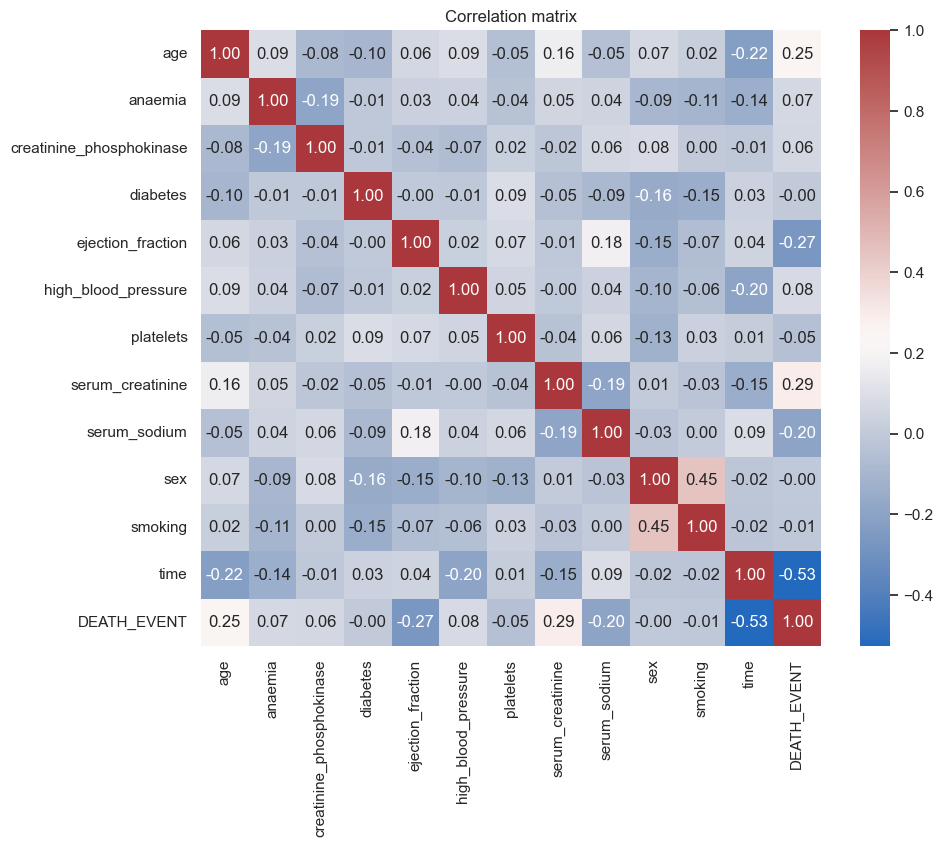

In [35]:
# Correlation heatmap (numeric)
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlation matrix')
plt.show()

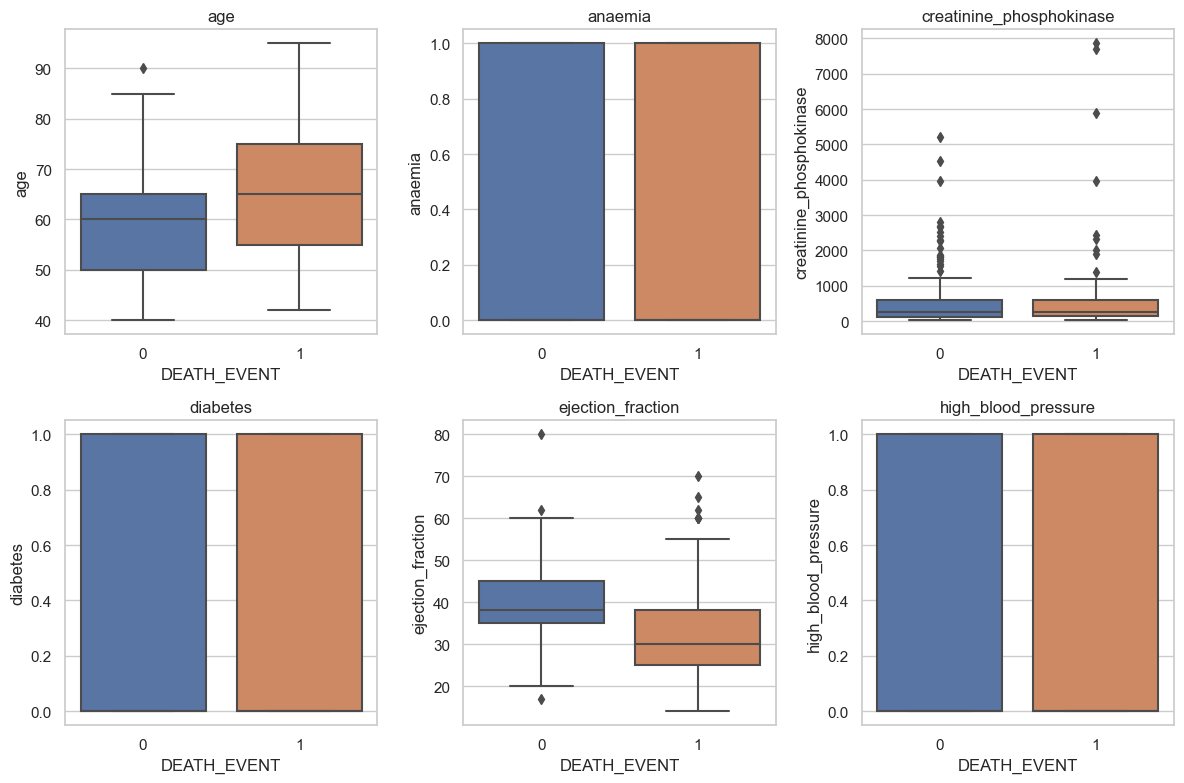

In [37]:
# Boxplots for key numeric features split by event
num_cols = df.select_dtypes(include=[np.number]).columns.drop(['time','DEATH_EVENT'])
plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2,3,i+1)
    sns.boxplot(x='DEATH_EVENT', y=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.show()

#### Data Preprocessing

In [41]:
# checking null values
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [42]:
# checking duplicate values
df.duplicated().sum()

0

In [38]:
X = df.drop(columns = ['DEATH_EVENT'])
y = df['DEATH_EVENT']

In [44]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
# Building pipeline to impute + scale
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
preproc = Pipeline([
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

In [46]:
X_train_proc = pd.DataFrame(preproc.fit_transform(X_train[num_features]), columns=num_features, index=X_train.index)
X_test_proc = pd.DataFrame(preproc.transform(X_test[num_features]), columns=num_features, index=X_test.index)

In [49]:
# building ML Models
results = {}

# logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_proc, y_train)

probs = lr.predict_proba(X_test_proc)[:,1]
preds = lr.predict(X_test_proc)
results['LogisticRegression'] = {
'accuracy': accuracy_score(y_test, preds),
'roc_auc': roc_auc_score(y_test, probs),
'precision': precision_score(y_test, preds),
'recall': recall_score(y_test, preds),
'f1': f1_score(y_test, preds)
}

In [51]:
# Random Forest Model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_proc, y_train)


probs = rf.predict_proba(X_test_proc)[:,1]
preds = rf.predict(X_test_proc)
results['RandomForest'] = {
'accuracy': accuracy_score(y_test, preds),
'roc_auc': roc_auc_score(y_test, probs),
'precision': precision_score(y_test, preds),
'recall': recall_score(y_test, preds),
'f1': f1_score(y_test, preds)
}

In [53]:
# XG Boost Model
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xg.fit(X_train_proc, y_train)

probs = xg.predict_proba(X_test_proc)[:,1]
preds = xg.predict(X_test_proc)
results['XGBoost'] = {
'accuracy': accuracy_score(y_test, preds),
'roc_auc': roc_auc_score(y_test, probs),
'precision': precision_score(y_test, preds),
'recall': recall_score(y_test, preds),
'f1': f1_score(y_test, preds)
}

In [55]:
# Showing results
print('\nClassification model results:')
for k,v in results.items():
    print(k, v)


Classification model results:
LogisticRegression {'accuracy': 0.8166666666666667, 'roc_auc': 0.858793324775353, 'precision': 0.7857142857142857, 'recall': 0.5789473684210527, 'f1': 0.6666666666666666}
RandomForest {'accuracy': 0.8166666666666667, 'roc_auc': 0.8844672657252889, 'precision': 0.7857142857142857, 'recall': 0.5789473684210527, 'f1': 0.6666666666666666}
XGBoost {'accuracy': 0.8333333333333334, 'roc_auc': 0.8267008985879332, 'precision': 0.8461538461538461, 'recall': 0.5789473684210527, 'f1': 0.6875}


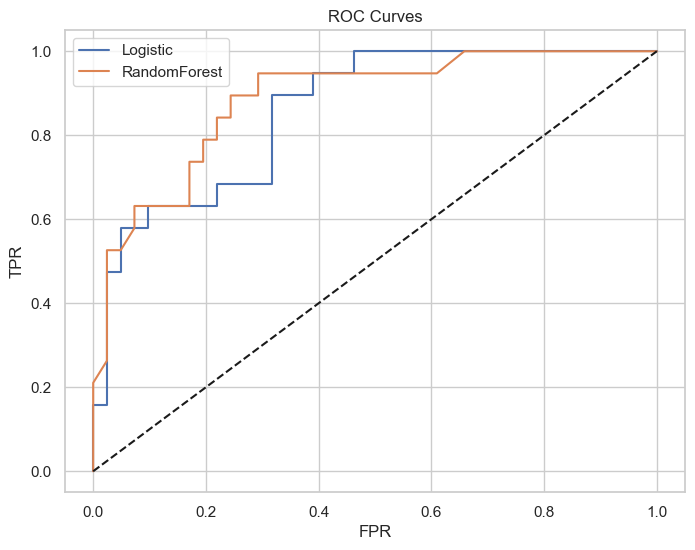

In [56]:
# Plot ROC for LR and RF
plt.figure(figsize=(8,6))
for name, model in [('Logistic', lr), ('RandomForest', rf)]:
    probs = model.predict_proba(X_test_proc)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend();
plt.show()

### Survival Analysis

In [68]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index

from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

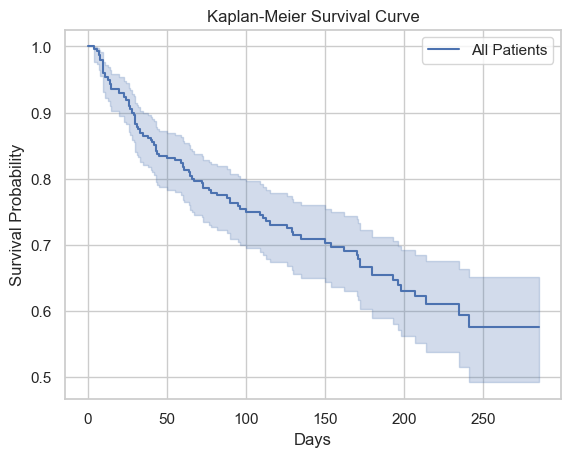

In [69]:
time = df['time']
event = df['DEATH_EVENT']

kmf = KaplanMeierFitter()
kmf.fit(time, event, label="All Patients")

kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.show()

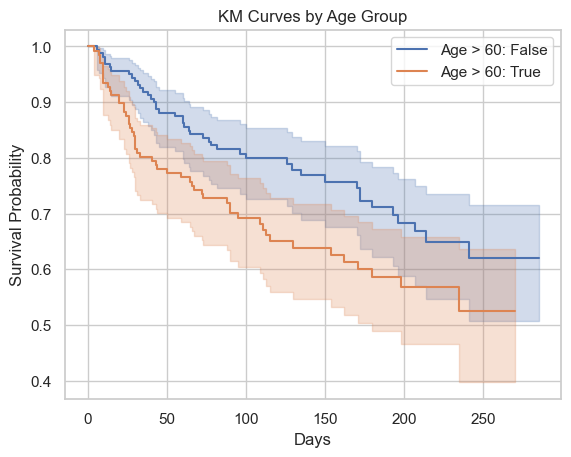

In [70]:
# Kaplan–Meier by Group
groups = df['age'] > 60
for label, grouped in df.groupby(groups):
    kmf.fit(grouped['time'], grouped['DEATH_EVENT'], label=f"Age > 60: {label}")
    kmf.plot_survival_function()

plt.title("KM Curves by Age Group")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.show()

In [71]:
# by seeing above plot we can say that
# Patients older than 60 had a steeper decline in survival probability, meaning higher risk.

In [72]:
# 2. Cox Proportional Hazards
cox_df = df[['time', 'DEATH_EVENT', 'age', 'ejection_fraction', 'serum_creatinine']]

cph = CoxPHFitter()
cph.fit(cox_df, duration_col='time', event_col='DEATH_EVENT')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -475.95
         time fit was run = 2025-09-04 15:03:51 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
age                0.04      1.05      0.01            0.03            0.06                1.03                1.06
ejection_fraction -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
serum_creatinine   0.36      1.43      0.07            0.22            0.49                1.25                1.63

                   cmp to     z      p  -log2(p)
covariate                                       
age                  0.00  4.93 <0.005     20.24
ejection_fraction    0.00 -4.80 <0.005     19.28
serum_creatinine     0.00  5.24 <0.005     22.60
---
Concordance = 0.72
Partial AIC = 957.90
log-likelihood ratio test = 66.51 on 3 df
-log2(p) of ll-ratio test = 45.25

In [73]:
# Random Survival Forest
y = Surv.from_dataframe("DEATH_EVENT", "time", df)
X = df[["age", "ejection_fraction", "serum_creatinine"]]

# Train RSF
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
                           min_samples_leaf=15, n_jobs=-1, random_state=42)
rsf.fit(X, y)

,n_estimators,100
,max_depth,None
,min_samples_split,10
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,bootstrap,True
,oob_score,False
,n_jobs,-1
,random_state,42


In [75]:
# Concordance Index
cindex = concordance_index_censored(y["DEATH_EVENT"], y["time"], rsf.predict(X))[0]
print("Concordance Index (RSF):", cindex)

Concordance Index (RSF): 0.7901421300297705


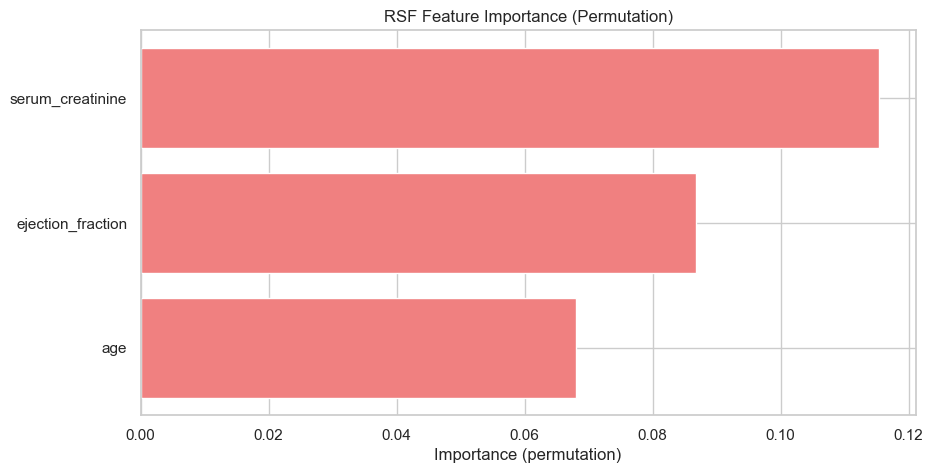

In [79]:
from sklearn.inspection import permutation_importance

# Computing permutation importance
result = permutation_importance(
    rsf, X, y, n_repeats=10, random_state=42, n_jobs=-1
)

importances = result.importances_mean
features = X.columns

# Plot
plt.figure(figsize=(10,5))
plt.barh(features, importances, color="lightcoral")
plt.xlabel("Importance (permutation)")
plt.title("RSF Feature Importance (Permutation)")
plt.show()

In [81]:
results

{'LogisticRegression': {'accuracy': 0.8166666666666667,
  'roc_auc': 0.858793324775353,
  'precision': 0.7857142857142857,
  'recall': 0.5789473684210527,
  'f1': 0.6666666666666666},
 'RandomForest': {'accuracy': 0.8166666666666667,
  'roc_auc': 0.8844672657252889,
  'precision': 0.7857142857142857,
  'recall': 0.5789473684210527,
  'f1': 0.6666666666666666},
 'XGBoost': {'accuracy': 0.8333333333333334,
  'roc_auc': 0.8267008985879332,
  'precision': 0.8461538461538461,
  'recall': 0.5789473684210527,
  'f1': 0.6875}}

In [82]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')